<a href="https://colab.research.google.com/github/manasuii/AI-ML_Fundamentals/blob/main/Oversmoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.9 MB/s eta 0:00:00


In [18]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt

In [19]:
#Graph Set_UP
edge_index = torch.tensor([[0,1,1,2,0,3,3,4,4,2],[1,0,2,1,3,0,4,3,2,4]], dtype=torch.long)
x = torch.tensor([[1.,0.,0.], [0.,1.,0.], [0.,0.,1.], [1.,1.,0.], [0.,1.,1.]])
y = torch.tensor([0,0,1,1,1], dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

In [21]:
#GNN model
class DeepGNN(torch.nn.Module):
    def __init__(self, num_layers):
        super().__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(3, 4))
        for _ in range(num_layers-2):
            self.convs.append(GCNConv(4, 4))
        self.convs.append(GCNConv(4, 2))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < self.num_layers - 1:  # No ReLU on last layer
                x = F.relu(x)
        return x

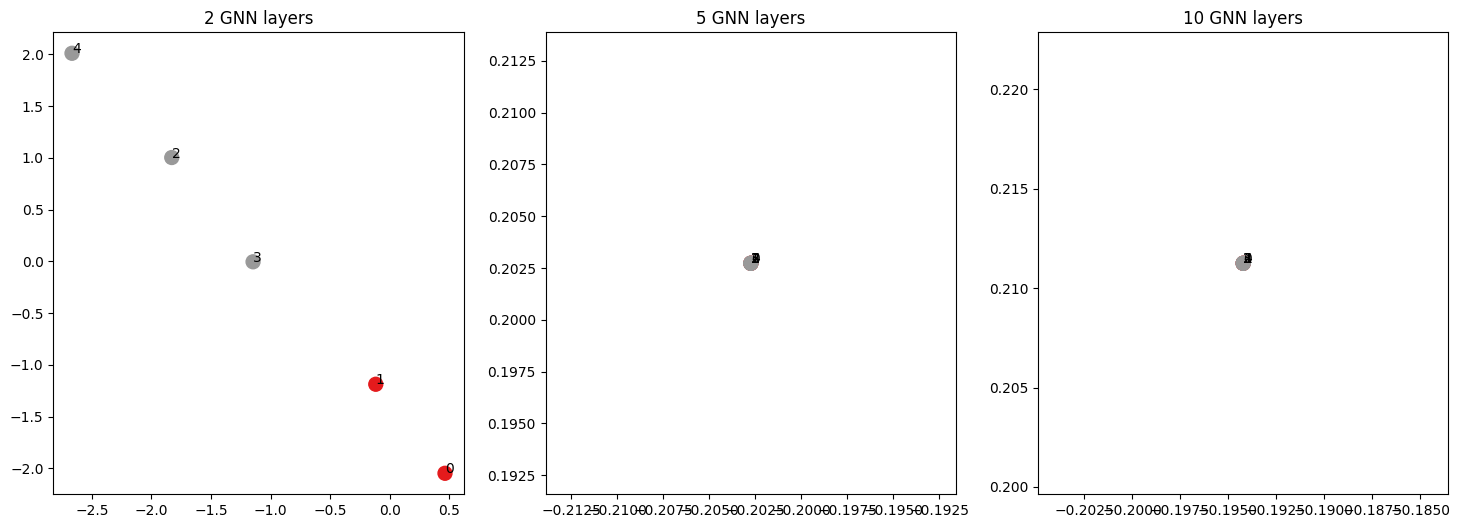

In [22]:
# Train & visualize embeddings for different depths
layers_list = [2, 5, 10]
fig, axes = plt.subplots(1, 3, figsize=(18,6))

for idx, num_layers in enumerate(layers_list):
    model = DeepGNN(num_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()


    model.train()
    for epoch in range(201):
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        emb = model(data.x, data.edge_index).numpy()


    axes[idx].scatter(emb[:,0], emb[:,1], c=data.y, cmap='Set1', s=100)
    for i in range(emb.shape[0]):
        axes[idx].text(emb[i,0], emb[i,1], f"{i}")
    axes[idx].set_title(f"{num_layers} GNN layers")

plt.show()


1. Here the GNN model with 2 Layers will cluster seperately and clusters are separated.
2. IN the GNN model with 5 layers the nodes start to move close to each other and there appears to be some mixing between the classes.
3. Finally in the 10 layer GNN the embeddings almost collapse to single cluster and node distinction is lost which is a clear sign of over-smoothing.

So, we can see that if there are limited number of layers there will be good seperation and the layers will still be task-aware. While if there are many layers(10+) there occurs over-smoothing and all the nodes will appear as identical.